In [72]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL
import cv2

from utils import *
from dark import *
from wrn4 import *

torch.backends.cudnn.benchmark = True

[autoreload of dark failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 376, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.7/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/opt/conda/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/workspace/kaggle_hpa/dark.py", line 51
    layers += self.make_group_layer(nf

In [73]:
MASKS = 'train.csv'

PATH = Path('./')

TRAIN = Path('train/')
TRAIN64 = Path('train64/')

TEST = Path('test/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

In [74]:
arch = Darknet([1,2,8,8,4], 28, 32, se=True)
# arch = wrn_22_10()

In [75]:
params= list(trainable_params(arch))

In [76]:
tot = 0
for t in params:
    tot += len(t.view(-1))

In [77]:
tot

54345532

In [78]:
def open_image4d(path:PathOrStr)->Image:
    '''open RGBA image from 4 different 1-channel files.
    return: numpy array [4, sz, sz]'''
    path=str(path)
    flags = cv2.IMREAD_GRAYSCALE
    red = cv2.imread(path+ '_red.png', flags)
    blue = cv2.imread(path+ '_blue.png', flags)
    green = cv2.imread(path+ '_green.png', flags)
    yellow = cv2.imread(path+ '_yellow.png', flags)
    im = np.stack(([red, green, blue, yellow]))

    return Image(Tensor(im/255).float())

# def open_image4d(path:PathOrStr)->Image:
#     '''open RGBA image from a single 4-channel file
#     return: numpy array [4, sz, sz]'''
#     path=str(path)
#     flags = cv2.IMREAD_UNCHANGED
#     im = cv2.imread(path+ '.png', flags)
#     return Image(Tensor(np.rollaxis(im, 2, 0)/255).float())


In [79]:
fname = train_names[0]

In [80]:
%time im = open_image4d(TRAIN/fname); 

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 18 ms


In [81]:
im.shape

torch.Size([4, 512, 512])

In [82]:
class Image4C_ds(ImageMultiDataset):
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Collection[Any]]=None):
        super().__init__(fns, labels, classes)
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray]: return open_image4d(self.x[i]), self.encode(self.y[i])
    def _get_x(self,i): return open_image4d(self.x[i])

In [83]:
from fastai.data_block import _df_to_fns_labels
fnames, labels = _df_to_fns_labels(seg, label_delim=' ', fn_col=0, label_col=1)
test_fnames, _ = _df_to_fns_labels(sample_sub, fn_col=0, label_col=1)

In [84]:
classes = uniqueify(np.concatenate(labels))

In [85]:
stats = ([0.485, 0.456, 0.406, 0.406], [0.229, 0.224, 0.225, 0.225])
norm,denorm = normalize_funcs(*stats)

In [86]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.2)

In [87]:
def get_data(sz=64, bs=64, is_test=False):
    folder=TRAIN
    test_ds=None
    if is_test: 
        t_names = [TEST/f for f in test_names]
        test_labels = [[classes[0]]] * len(test_names)
        test_ds = Image4C_ds(t_names, test_labels, classes)
    train, val = Image4C_ds.from_folder(PATH, folder, fnames, labels, valid_pct=0.2, classes=classes)
    return ImageDataBunch.create(train_ds=train, valid_ds=val, test_ds=test_ds,
                                 ds_tfms=tfms, tfms=norm, bs=bs, size=sz)


In [88]:
# train, val = Image4C_ds.from_folder(PATH, TRAIN, fnames, labels, valid_pct=0.2, classes=classes)

In [89]:
class_sample_count = array([12885,  1254,  3621,  1561,  1858,  2513,  1008,  2822,    53,
          45,    28,  1093,   688,   537,  1066,    21,   530,   210,
         902,  1482,   172,  3777,   802,  2965,   322,  8228,   328,
          11])
print(class_sample_count)

[12885  1254  3621  1561  1858  2513  1008  2822    53    45    28  1093   688   537  1066    21   530   210   902
  1482   172  3777   802  2965   322  8228   328    11]


In [90]:
# from torch.utils.data.sampler import WeightedRandomSampler
# wrs = WeightedRandomSampler(weight, len(weight))

In [91]:
def get_learner(data, focal=False, fp16=False, load_model='dk_small_128'):
    learn = Learner(data, arch , metrics=[accuracy_thresh, f1])
    if focal: learn.loss_func=FocalLoss()
    if fp16: learn.to_fp16();
    learn.load(load_model)
    return learn.mixup(stack_y=False)

# 64

In [93]:
data = get_data(64, 128, True)
learn = Learner(data, arch , metrics=[accuracy_thresh, f1]).to_fp16().mixup(stack_y=False)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


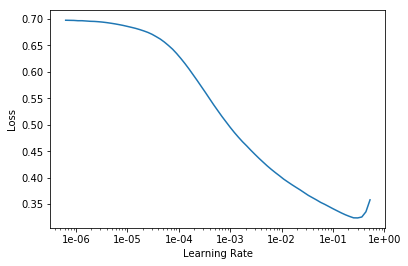

In [94]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-3
%time learn.fit_one_cycle(10, lr, wd=0.2, div_factor=10, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.168512,0.168322,0.944927,0.169780


# 128

In [36]:
data = get_data(64, 64, True)
learn = get_learner(data, focal=True, fp16=True, load=True)

In [30]:
learn.loss_func=FocalLoss2d()

In [33]:
lr = 1e-3

In [37]:
%time learn.fit_one_cycle(10, lr/10, wd=0.2, div_factor=10, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy_thresh,f1


KeyboardInterrupt: 

In [32]:
# learn.save('dk_small_128')

# 256

In [38]:
data = get_data(256, 32, True)
learn = get_learner(data, focal=True, fp16=True, load=True)
lr = 1e-3

In [39]:
learn.fit_one_cycle(30, lr/10, wd=0.2, div_factor=10, pct_start=0.5)

Total time: 3:04:45
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.771201    0.740258    0.964988         0.576388  (06:17)
2      0.738599    0.718715    0.965941         0.610401  (06:07)
3      0.743672    0.714801    0.966061         0.619789  (06:10)
4      0.720661    0.709069    0.966352         0.616876  (06:08)
5      0.751419    0.708755    0.966552         0.611740  (06:09)
6      0.728126    0.710326    0.966523         0.612481  (06:09)
7      0.727537    0.703583    0.966860         0.634245  (06:09)
8      0.729292    0.708085    0.966700         0.629488  (06:09)
9      0.728417    0.703185    0.966324         0.622278  (06:09)
10     0.718099    0.721909    0.965519         0.611132  (06:10)
11     0.704615    0.761682    0.964731         0.626543  (06:09)
12     0.708886    0.720824    0.966420         0.641063  (06:10)
13     0.714534    0.717520    0.965953         0.610833  (06:09)
14     0.716870    0.746732    0.965005         0.621779  (06:10)

In [40]:
# learn.save('dk_small_256')

# 512

In [20]:
data = get_data(512, 8, True)
lr = 1e-3

In [23]:
learn = get_learner(data, focal=True, fp16=True, load_model='dk_small_256')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


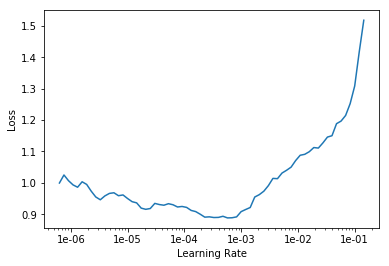

In [24]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, 1e-4, wd=0.2, div_factor=10, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.758586,0.751955,0.965620,0.626488
2,0.735641,0.743920,0.966191,0.643402
3,0.755143,0.822003,0.963370,0.616606
4,0.733197,0.839083,0.964245,0.616319
5,0.722798,1.101252,0.957642,0.573184


# Validation and Preds

In [41]:
# learn.data.test_dl.add_tfm(to_half)
# learn.data.valid_dl.add_tfm(to_half)

In [42]:
p,t = learn.get_preds(ds_type=DatasetType.Test)

In [43]:
p.shape

torch.Size([11702, 28])

In [44]:
#valid data
learn.data.valid_dl.add_tfm(to_half)
p_v, t_v = learn.get_preds()

In [45]:
p_v.shape

torch.Size([6257, 28])

In [46]:
def f1_np(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred>threshold).astype(int)
    TP = (y_pred*y_true).sum(1)
    prec = TP/(y_pred.sum(1)+1e-7)
    rec = TP/(y_true.sum(1)+1e-7)
    res = 2*prec*rec/(prec+rec+1e-7)
    return res.mean()

In [47]:
p_v_s = p_v.sigmoid()

In [48]:
f1(p_v, t_v)

tensor(0.7002)

In [49]:
p_v_np, t_v_np = to_np(p_v_s), to_np(t_v)

In [50]:
f1_np(p_v_np, t_v_np)

0.7002198587896546

In [51]:
def f1_n(y_pred, y_true, thresh, n, default=0.5):
    threshold = default * np.ones(y_pred.shape[1])
    threshold[n]=thresh
    return f1_np(y_pred, y_true, threshold)

In [52]:
def find_thresh(y_pred, y_true):
    ths = []
    for i in range(y_pred.shape[1]):
        aux = []
        for th in np.linspace(0,1,100):
            aux += [f1_n(y_pred, y_true, th, i)]
        ths += [np.array(aux).argmax()/100]
    return np.array(ths)

In [53]:
x = np.linspace(0,1,100)

In [54]:
y = np.array([f1_n(p_v_np, t_v_np, th, 1) for th in x])

In [55]:
import matplotlib.pyplot as plt

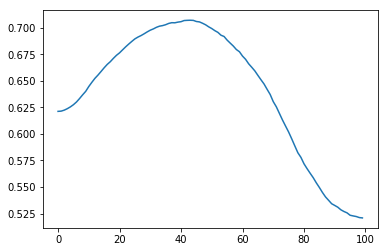

In [56]:
plt.plot(y)

In [57]:
ths = find_thresh(p_v_np, t_v_np)

In [58]:
ths

array([0.48, 0.43, 0.34, 0.39, 0.36, 0.41, 0.38, 0.42, 0.36, 0.36, 0.39, 0.39, 0.29, 0.37, 0.32, 0.44, 0.45, 0.44,
       0.35, 0.38, 0.42, 0.36, 0.33, 0.46, 0.58, 0.38, 0.23, 0.35])

In [59]:
f1_np(p_v_np, t_v_np, 0.4)

0.7358056522831731

# Sub File

In [60]:
preds = to_np(p.sigmoid())
threshold = ths
print(preds.shape)
classes = np.array(classes)
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

(11702, 28)


In [61]:
classes

array(['16', '0', '7', '1', '2', '5', '18', '25', '23', '21', '24', '6', '11', '3', '12', '13', '14', '4', '20', '22',
       '17', '19', '8', '9', '10', '26', '27', '15'], dtype='<U2')

In [62]:
frame = pd.DataFrame(np.array([test_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv('my_submission.csv', index=False)

In [63]:
frame.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,25 23
